In [1]:
import rebound
import rebound.data
print(rebound.__build__)
import numpy as np
import os
import time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from rebound.plotting import fading_line
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

Feb 26 2020 16:11:25


In [2]:
simwo = rebound.Simulation()
rebound.data.add_outer_solar_system(simwo)
simwo.move_to_com()
simw = simwo.copy()
for i in range(20):
    simw.add(m=1e-5,a=5+10./20.*i,e=0.1,f=i)    
simw.move_to_com()

In [3]:
P0 = simwo.particles[1].P
P0

74.56162171191815

In [4]:
def run(settings):
    kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells = settings
    sim2 = sim.copy()
    sim2.dt = dt
    if phi0 == "whfast":
        sim2.ri_whfast.safe_mode= 0
        sim2.integrator = "whfast"
    else:
        sim2.ri_mercurana.kappa0 = kappa0
        sim2.ri_mercurana.kappa1 = kappa1
        sim2.ri_mercurana.phi0 = phi0
        sim2.ri_mercurana.phi1 = phi1
        sim2.ri_mercurana.n0 = n0
        sim2.ri_mercurana.n1 = n1
        sim2.ri_mercurana.safe_mode = 0    
        sim2.ri_mercurana.Nmaxshells = Nmaxshells
        sim2.ri_mercurana.N_dominant = N_dominant
        sim2.integrator = "mercurana"

    times = np.linspace(0.,1000.,64)
    E0 = sim2.calculate_energy()
    E = 0.
    start = time.perf_counter()
    for i, t in enumerate(times):
        sim2.integrate(t,exact_finish_time=False)
        E1 = sim2.calculate_energy()
        E = max(E,np.abs((E1-E0)/E0))
    return E, time.perf_counter()-start, sim2.ri_mercurana.Nmaxshellused

In [5]:
def runbatch(settings):
    kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells = settings
    res = []
    dts = np.logspace(dt[0],dt[1],dt[2])
    for dt in dts:
        if phi0=="lf" and phi1=="none":
            kappa0 = 0.28*dt
            kappa1 = 0.28*dt
        if phi0=="lf4_2" and phi1=="lf4":
            kappa0 = 0.28*dt/30.
            n0 = int(dt/1e-3)
            if n0<2: 
                n0 = 2
            print(dt,n0)
            kappa1 = np.sqrt(7.6e-5*dt)
        if phi0=="lf4_2" and phi1=="lf":
            kappa0 = dt/70.
            kappa1 = dt*0.281e-3/100
            print(dt,kappa0,kappa1)
        if phi0=="lf" and phi1=="lf":
            kappa0 = dt/70.
            kappa1 = dt*0.27 /n0            
        res.append(run([kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells]))
    return res

In [6]:
reswo = []
settings = [
    [1e-1, 1e-1, "lf", "none", 2, 0, 0, [-3,1,50], 20],
    #[1e-1, 1e-1, "lf4_2", "lf4", 30, 2, 1, [-2,2,20], 20],
    #[1e-1, 1e-1, "lf4_2", "lf", 1000, 2, 1, [-2,2,20], 20],
    [1e-1, 1e-1, "lf", "lf", 30, 2, 1, [-2,1,50], 20],
]
sim = simwo
for setting in settings:
    reswo.append(runbatch(setting))

In [7]:
res = []
sim = simw
for setting in settings:
    res.append(runbatch(setting))

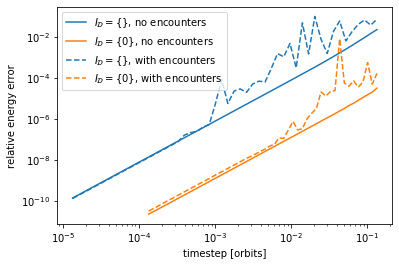

In [8]:
fig, ax = plt.subplots(1,1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("timestep [orbits]")
ax.set_ylabel("relative energy error")
for i,setting in enumerate(settings):
    kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells = setting
    dts = np.logspace(dt[0],dt[1],dt[2])
    _res = np.array(reswo[i])
    if N_dominant==0:
        label = "$I_\mathcal{D} = \\{\\}$, no encounters"
    else:
        label = "$I_\mathcal{D} = \{0\\}$, no encounters"
    ax.plot(dts/P0,_res[:,0],label=label)
plt.gca().set_prop_cycle(None)    
for i,setting in enumerate(settings):
    kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells = setting
    dts = np.logspace(dt[0],dt[1],dt[2])
    _res = np.array(res[i])
    if N_dominant==0:
        label = "$I_\mathcal{D} = \\{\\}$, with encounters"
    else:
        label = "$I_\mathcal{D} = \{0\\}$, with encounters"
    ax.plot(dts/P0,_res[:,0],ls="--",label=label)
ax.legend(loc="upper left")      
plt.savefig("figurecloseencounters.pdf", bbox_inches = 'tight', pad_inches = 0)
os.system("cp figurecloseencounters.pdf ~/papers/mercurana/");

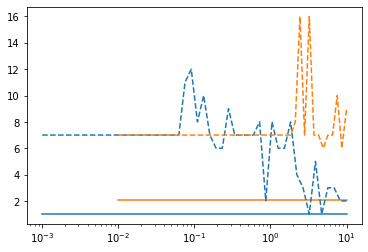

In [9]:
fig, ax = plt.subplots(1,1)
ax.set_xscale("log")
for i,setting in enumerate(settings):
    kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells = setting
    dts = np.logspace(dt[0],dt[1],dt[2])
    _res = np.array(reswo[i])
    ax.plot(dts,_res[:,2]+i/10.,label="%s"%setting)
plt.gca().set_prop_cycle(None)   
for i,setting in enumerate(settings):
    kappa0, kappa1, phi0, phi1, n0, n1, N_dominant,dt,Nmaxshells = setting
    dts = np.logspace(dt[0],dt[1],dt[2])
    _res = np.array(res[i])
    ax.plot(dts,_res[:,2],ls="--")